In [1]:
%matplotlib inline

# Do this to add the above directory to system path 
import sys
sys.path.append('../../duq/mcmc_regression/')
  
# Importing the Bayesian LR module
from BLRPy import *

# Performing 1D Bayesian Linear Regression Using the Metropolis MCMC (Markov-Chain Monte Carlo) Algorithm - Plain Python

## Linear Regression Overview
In linear regression, we are looking for a function $f$ that maps inputs $x \in \mathbb{R}^D$ to corresponding function values $f(x) \in \mathbb{R}$: i.e. it can extract the relationship between multiple inputs and a single output value. For the purposes of this notebook, I'll only be looking at 1D linear regression where a single input feature ($x$) maps to the output target ($y$), and the regression line will be first-order (i.e. only one $x$ coefficient). 

Bayesian linear regression does not look for a point estimate of a target given a feature, but instead formulates the regression using probability distributions by determining the posterior distribution for the model parameters. 

The standard form for a first-order, 1D linear regression is given as:

$$ y = \theta_0 + \theta_1x_1 + \epsilon$$

Where $\theta_0$ is the intersept of the curve, $\theta_1$ is the slope of the curve and $\epsilon$ is a noise term, describing the deviation of the observed features from the regression line.

This can be generalised in matrix form as:

$$ y = \mathbf{\theta^T X} + \epsilon $$

So in general:

$$ y = \begin{bmatrix} \theta_{0} & \theta_{1} & \cdots & \theta_{n} \end{bmatrix} \begin{bmatrix}
           x^{0} \\
           x^{1} \\
           \vdots \\
           x^{n}
         \end{bmatrix} + \epsilon$$ 

And so in the 1D case:

$$ y =  \begin{bmatrix} \theta_{0} & \theta_{1} \end{bmatrix} \begin{bmatrix}
           1 \\
           x 
         \end{bmatrix} + \epsilon $$ 


Our goal now in typical linear regression is to find the exact values of $\theta_0$ and $\theta_1$ that minimise the MSE (Mean Squared Error), but in Bayesian linear regression we're looking to infer posterior distributions for each parameter. 

## Probabilistic Linear Regression
If we now model the noise term ($\epsilon$) for simplicity as a normal distribution, it will be centered around 0 ($\mu = 0$) with some unknown standard deviation ($\sigma^2$) we can therefore express it as: 
$$ \epsilon \sim \mathcal{N}(0, \sigma^2) $$

Combining this with the result for the matrix form of linear regression above, we get to the following:

$$ p(y|\mathbf{X},\mathbf{\theta}) = \mathcal{N}(\mathbf{X^T\theta},\sigma^2)$$

Which says that our likelihood of our targets given the features and model parameters is equal to a normal distribution centered at a mean value of $\mathbf{X^T\theta}$ with a standard deviation of $\sigma^2$.

Our goal now then is to find the correct values of $\theta_0$, $\theta_1$ and $\sigma^2$ that most accurately describes our dataset.

## Bayesian Linear Regression
### Theory
Bayes theorem is given as:

$$ P(\mathbf{\theta} | y, \mathbf{X}) = \frac{P(y|\mathbf{\theta})P(\mathbf{\theta})}{P(\mathbf{X})} $$

Where $P(\mathbf{\theta} | y, \mathbf{X})$ is the **posterior**, $P(y|\mathbf{\theta})$ is the **likelihood**, $P(\mathbf{\theta})$ is the **prior**, and $P(\mathbf{X})$ is the **evidence** (sometimes also called the **normalisation** term).

Since our goal is to calculate the *posterior* we need to know the likelihood, prior and evidence terms. The numerator of the theorem (likelihood and prior) are known quantities, but for most problems the evidence term is intractible - i.e. we cannot form a closed-form analytic solution. 

We can form a closed-form solution if we're able to form a *conjugate prior* (possible when we have a normal likelihood with a known standard deviation), but for the purposes of this notebook I'll be focussing on the scenario where we cannot form an analytical solution, where we need to use a posterior sampling method such as **MCMC**.

### MCMC Algorithm (Metropolis)
The MCMC algorithm combines the Monte-Carlo method (i.e. sampling from random distributions) and the Markov Chain methods (i.e. where the next iteration is dependent on the current iteration) with an additional step of logic outlining when to keep a new sample or not.

The outline of the algorithm is as follows, given we have $M$ datapoints and are performing $N$ iterations.
#### For iteration $i = 0$ only:
1. Set out initial guesses for the mean values for each parameter ($\theta_0^{(i=0)}$, $\theta_1^{(i=0)}$, $\sigma^{2 (i=0)}$) and proposal widths for the sampling ($\sigma^2_{\theta_0}$, $\sigma^2_{\theta_1}$, $\sigma^2_{\sigma^2}$)

#### Repeating for every iteration until $i = N$
2. Create normal distributions using the current parameter estimations and proposal widths, i.e.:
    - $\mathcal{N}(\theta_0^{(i)}, \sigma^2_{\theta_0})$
    - $\mathcal{N}(\theta_1^{(i)}, \sigma^2_{\theta_1})$
    - $\mathcal{N}(\sigma^{2 (i)}, \sigma^2_{\sigma^2}$)
3. Take a single random sample from each of these new distributions to get proposed values for each parameter: $\theta_0^{(i+1)*}$, $\theta_1^{(i+1)*}$ and $\sigma^{2 (i+1)*}$
4. Use the proposed values for each parameter to create a new proposal target set: $\hat{y} = \theta_0^{(i+1)*} + \theta_1^{(i+1)*}\mathbf{X}$ (where $\hat{y}^T = [\hat{y}_0, \hat{y}_1, \hat{y}_2 \dots \hat{y}_N]$)
4. Calculate likelihood: 
    - Create a normal distribution centered around every $\hat{y}_j$ with the current standard deviation $\sigma^{2 (i+1)*}$: $L_j = \mathcal{N}(\hat{y}_j, \sigma^{2 (i+1)*})$
    - For every $L_j$, calculate the log likelihood of the jth observed target from the dataset $y_j$ appearing in the distribution (i.e. a PDF of point $y_j$ in distribution $L_j$)
    - Sum the $M$ log likelihoods together to get a total likelihood $P(y|\mathbf{X},\mathbf{\theta})$
5. Calculate the Prior:
    - Make some assumptions on the properties of the prior, e.g.:
        - $\theta_{0, prior} = \mathcal{N}(0,5)$
        - $\theta_{1, prior} = \mathcal{N}(0,5)$
        - $\sigma^2_{prior} = \mathcal{N}(0,5)$
    - Calculate the log probability of our current paramater values occuring in these distributions, i.e. the PDF. We then have $P(\theta_0)$, $P(\theta_1)$ and $P(\sigma^2)$ 
    - Add these priors together to get a total prior probability ($P(\mathbf{\theta})$)
6. Calculate the numerator for the proposed parameter distributions (note: result is a single probability):
    - Add the log probabilities of the Prior and Likelihood together to get $P(y|\mathbf{X},\mathbf{\theta}^*)P(\mathbf{\theta}^*)$
7. Calculate the numerator for the current parameter distributions (note: result is a single probability):
    - Repeat steps $4$ and $5$, except using the current parameter values ($\theta_0^{(i)}$, $\theta_1^{(i)}$ and $\sigma^{2 (i)}$) instead of the proposed values ($\theta_0^{(i+1)*}$, $\theta_1^{(i+1)*}$ and $\sigma^{2 (i+1)*}$)
    - Add the log probabilities of the Prior and Likelihood together to get $P(y|\mathbf{X},\mathbf{\theta})P(\mathbf{\theta})$
8. Based on the current and proposed numerators, calculate the acceptance rate:
    - Acceptance rate = $exp({P(y|\mathbf{X},\mathbf{\theta}^*)P(\mathbf{\theta}^*) - P(y|\mathbf{X},\mathbf{\theta})P(\mathbf{\theta})})$
9. Decide whether to keep proposed parameters or not:
    - If the acceptance rate is greater or equal than a random uniform number (between $0$ and $1$), then accept the proposed parameters and add them to the chain, otherwise reject them and bring the previous parameters to the next iteration.
10. Repeat from step 2 until N iterations have been completed.







This method gets around the intractibility of the evidence term by performing a division of the numerator of Bayes theorem:

$$ 
\frac
{P(y | \mathbf{X,\theta^*})P(\mathbf{\theta^*})}
{P(y | \mathbf{X,\theta})P(\mathbf{\theta})} 
= 
\frac
{\frac{P(y | \mathbf{X,\theta^*})P(\mathbf{\theta^*})}{P(\mathbf{X})}}
{\frac{P(y | \mathbf{X,\theta})P(\mathbf{\theta})}{P(\mathbf{X})}}
$$

#### To do: Define Metropolis-Hastings Algorithm

# Define the Dataset

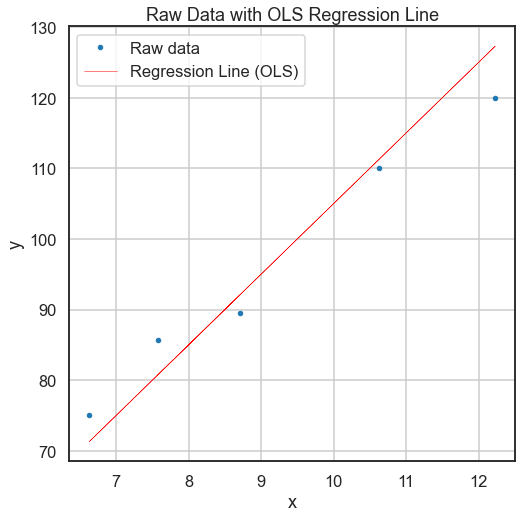

In [2]:
""" Option 1: Creating a LR object with a new dataset with default parameters 
N=50, true_theta0=2, true_theta1=4, true_sd = 2 """
#LR = BLR(BLR.create_dataset(BLR))

""" Option 2: Creating a LR object with a new dataset with custom parameters """
LR = BLR(BLR.create_dataset(BLR, 
                            N=5, 
                            true_theta0 = 5, 
                            true_theta1 = 10, 
                            true_sd = 3))

""" Option 3: Creating a LR object with an existing dataset """
#N = 100
#X = norm(10,np.sqrt(5)).rvs(N)    # Sample N number of x values that have a mean of 10 and a std dev of sqrt(5)
#Y = 5 + 10*X + norm(0,3).rvs(N) # Sample N number of y values based on slope and intersept plus a noise value
#raw_data = [X, Y]
#LR = BLR(raw_data)

# Extract the X and Y values from LR
X = LR.dataset[0]
Y = LR.dataset[1]

# Create plot 
plt.figure(figsize=(8, 8))
poly1d_fn = np.poly1d([LR.true_params[1],LR.true_params[0]])  # Create function to plot the regression line  
plt.plot(X,Y,'.',label="Raw data")                                         # Plot the raw data
plt.plot(X,poly1d_fn(X),'-r',linewidth=0.5,label="Regression Line (OLS)")  # Plot the regression line 
plt.title("Raw Data with OLS Regression Line")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()



## Run the MCMC Sampler

In [3]:
# Metropolis
#chain = LR.MCMC_Metropolis(iterations=500, burnin=0)

# Metropolis-Hastings
chain = LR.MCMC_Metropolis_Hastings(theta=[3,6,2],iterations=20_000, burnin=5_000)

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:30<00:00, 132.76it/s]

Acceptance rate:  0.6311333333333333
Time taken: 150.66 seconds


#### Save the LR object to file

In [4]:
LR.save("LR_Jupyter_20000_5_points")

#### Load the LR object from file

In [5]:
LR = BLR.load("LR_Jupyter_20000_5_points")
print(LR.true_params)
#LR = BLR.load("LR_Jupyter_500")

[5, 10, 3]


## Plot Results - Metropolis-Hastings

### Instantiate the BLR_Plots object

In [6]:
# Instantiate a BLR_Plots object
Plots = BLR_plots(LR.chain)

# Set the true parameters of the plots object (optional)
Plots.true_params = LR.true_params

### Plot the trace and belief

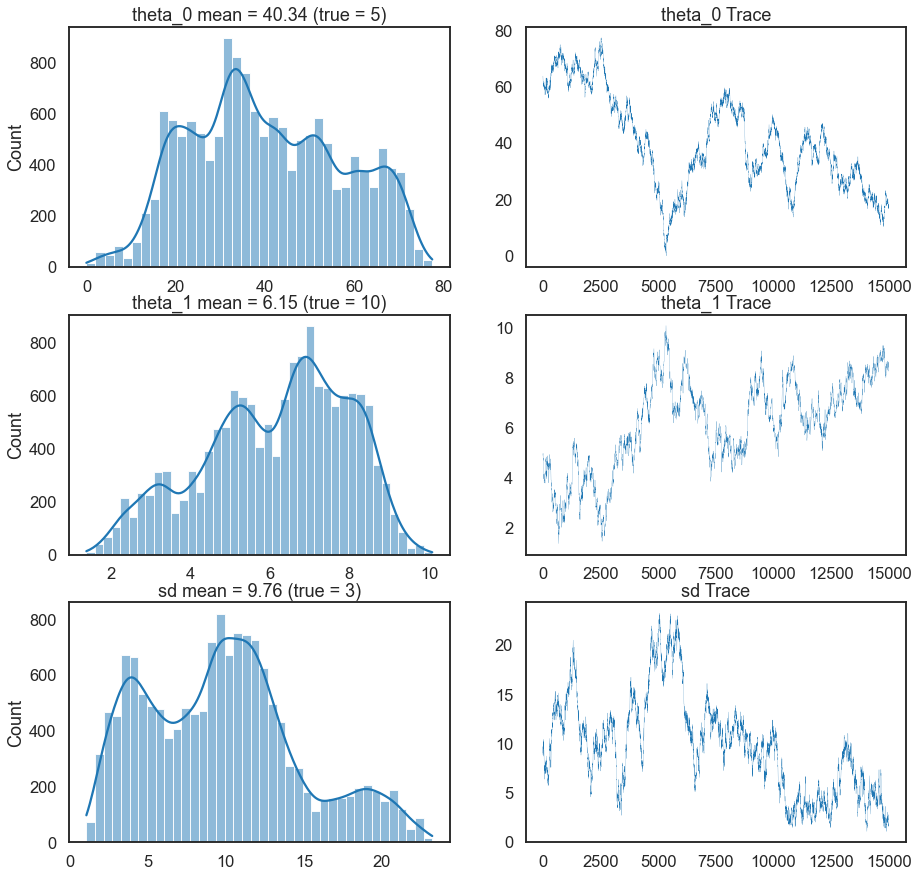

In [7]:
Plots.trace()

### Plot the Autocorrelation
"This cone pictures the confidence level (by default set to 95%). In other words, if the point is outside the cone (on white) you may say that with 95% probability is has a certain impact on values. If the bar is inside the cone (on blue) you may ignore this particular lag as most likely it is not relevant.

Now, the bars, which are vital here. They show you how much past data point impacts the following ones." ([1]) 

The x axis describes the lag, which is how far back the autocorrelation is looking.

[1]: https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711

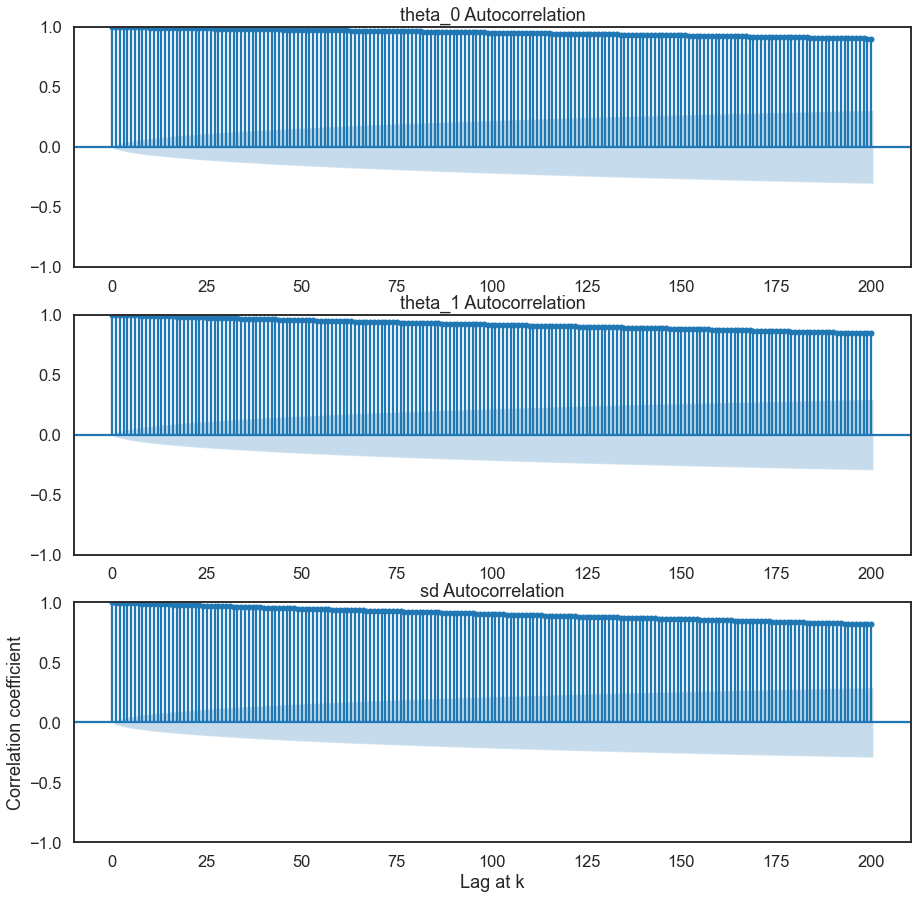

In [8]:
Plots.autocorr(lags=200)

### Bivariate Plot - How $\theta_0$ and $\theta_1$ Change w.r.t. Iterations

C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aolux\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


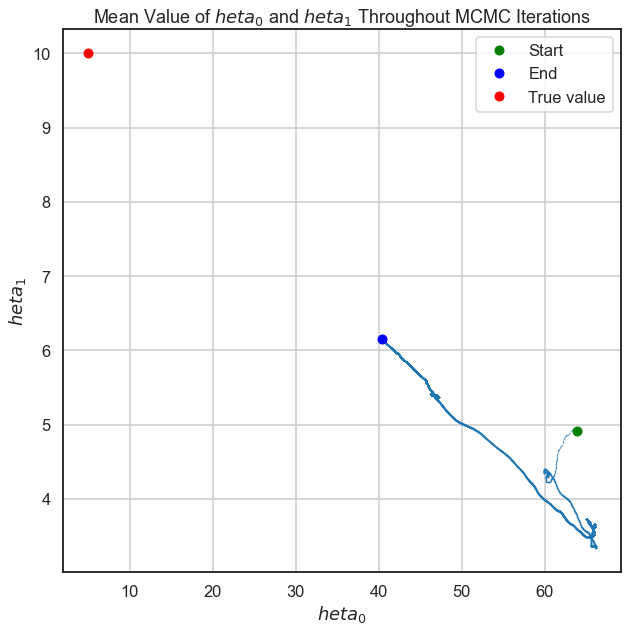

In [9]:
Plots.bivariate()

### Plot the X and Y data, as well as various curves sampled from the posterior

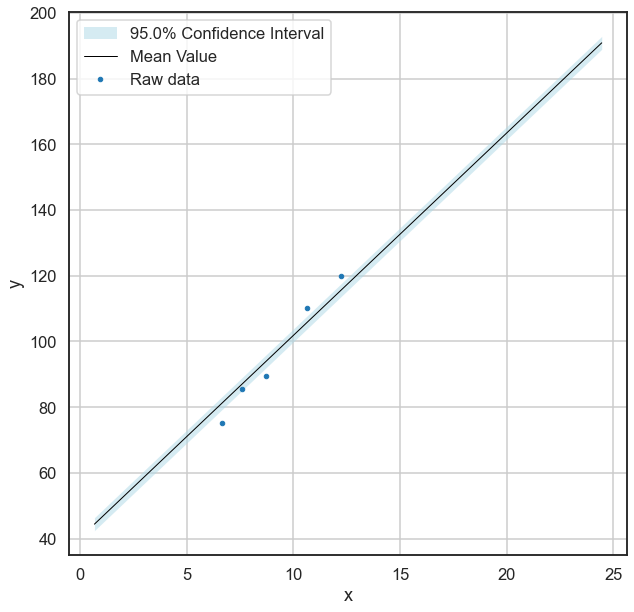

In [16]:
Plots.curves(X=LR.dataset[0], Y=LR.dataset[1], num_lines=0, mode=1, interval=True, alpha=0.95, line_opacity=0.01, fill_opacity=0.5, fill_colour='lightblue')

### Make a Prediction from the Posterior Distribution

C:\Users\aolux\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


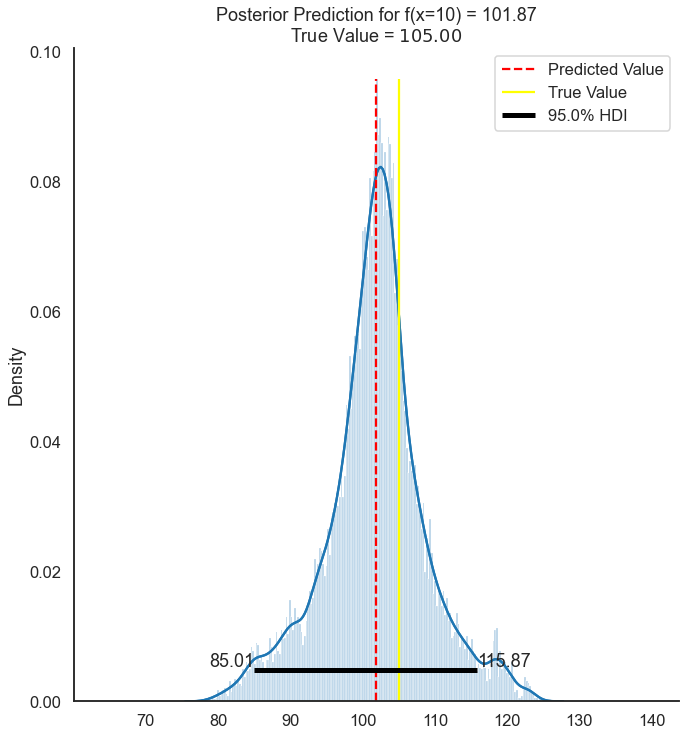

In [11]:
# Predict f(x=20)
Plots.posterior_prediction(10, alpha=0.05)

***
## Comparison Against PyMC3

In [12]:
# Adapted from: https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7
import pymc3 as pm

with pm.Model() as linear_all_data:
    
    intercept = pm.Normal('Intercept', mu = 0, sd = 5)  # Intersept
    slope = pm.Normal('slope', mu = 0, sd = 5)          # Slope
    sigma = pm.HalfNormal('sigma', sd = 5)              # Standard Deviation
    
    mean = intercept + slope * X                         # Estimate of mean 
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y) # Observed values
    
    step = pm.NUTS()                                     # Sampler
    linear_trace = pm.sample(50_000,step, chains=2,return_inferencedata=True)                  # Posterior Distribution

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 50_000 draw iterations (2_000 + 100_000 draws total) took 70 seconds.
There were 1552 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3780 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6649445911624294, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\aolux\AppData\Local\Temp\ipykernel_12264\1118710658.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(linear_trace, figsize=(12,12))


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

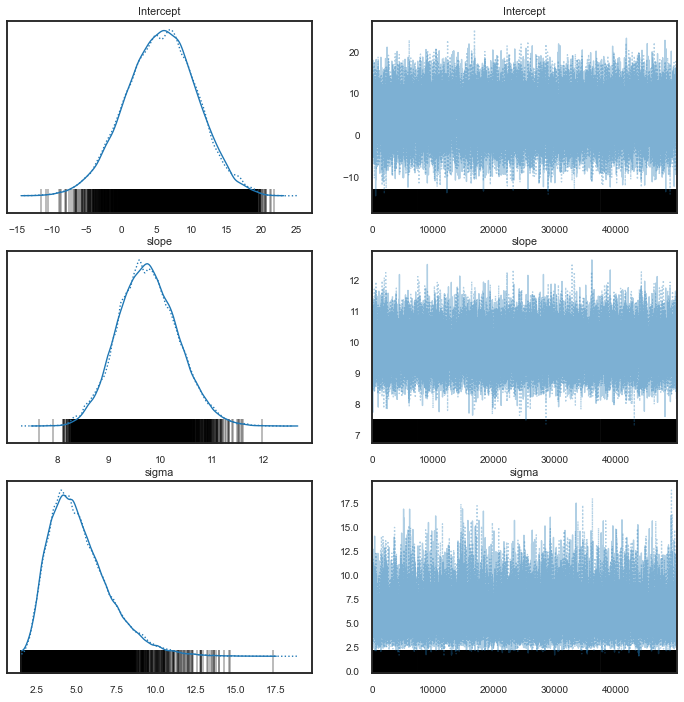

In [13]:
pm.traceplot(linear_trace, figsize=(12,12))

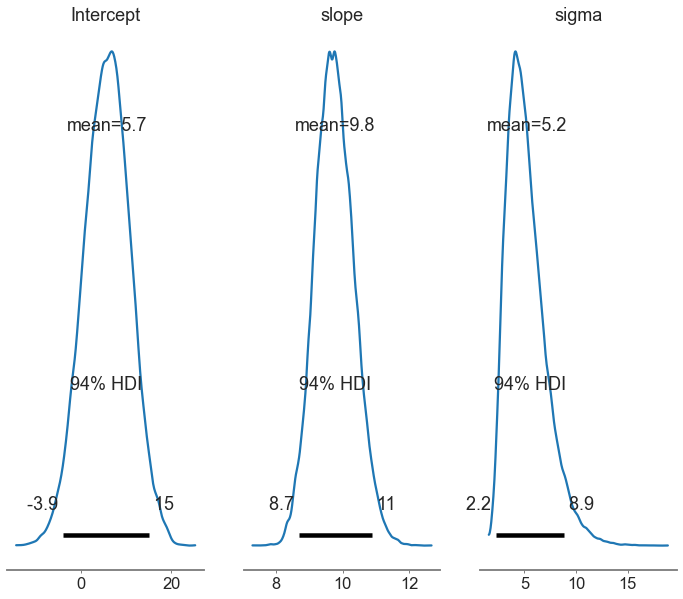

In [14]:
pm.plot_posterior(linear_trace, figsize= (12,10));

C:\Users\aolux\anaconda3\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


NameError: name 'true_theta0' is not defined

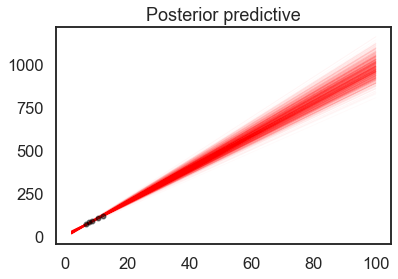

In [15]:
plt.subplot(111)
plt.scatter(X, Y, color='black', s = 20, alpha = 0.5, label='sample data', zorder = 3)
pm.plot_posterior_predictive_glm(linear_trace, samples = 1000, eval=np.linspace(2, 100, 100), linewidth = 1, color = 'red', alpha = 0.02, label = 'Bayesian Posterior Models',lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x, zorder = 1)
plt.plot(X, true_theta0 + true_theta1*X, label='True Regression Line', color = 'black', zorder= 2)
plt.title('Bayesian Regression'); plt.xlabel('x'); plt.ylabel('y')
plt.xlim(0,20)
plt.ylim(0,100)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

In [ ]:
print("Insercept mean value (chain 1): ",linear_trace.posterior['Intercept'].values[0].mean())
print("Insercept mean value (chain 2): ",linear_trace.posterior['Intercept'].values[1].mean())

print("Slope mean value (chain 1): ",linear_trace.posterior['slope'].values[0].mean())
print("Slope mean value (chain 2): ",linear_trace.posterior['slope'].values[1].mean())

print("SD mean value (chain 1): ",linear_trace.posterior['sigma'].values[0].mean())
print("SD mean value (chain 2): ",linear_trace.posterior['sigma'].values[1].mean())

intercept_mean = 0.5*(linear_trace.posterior['Intercept'].values[0].mean() + linear_trace.posterior['Intercept'].values[1].mean())
slope_mean = 0.5*(linear_trace.posterior['slope'].values[0].mean() + linear_trace.posterior['slope'].values[1].mean())
sd_mean = 0.5*(linear_trace.posterior['sigma'].values[0].mean() + linear_trace.posterior['sigma'].values[1].mean())

print(f"Intercept mean = {intercept_mean:.2f}, slope mean = {slope_mean:.2f}, sd mean = {sd_mean:.2f}")